# CIFAR-10 이미지 생성하기

## Step 1. 작업환경 구성하기

![디렉토리 만들기](https://user-images.githubusercontent.com/116326867/208328548-4412d3f9-a82d-4943-940d-40adeb176ccd.png)

- generated_samples로 directory를 만들었어야 했는데 오타로 generatied_samples가 돼서 directory 이름 변경이 있었다.

In [1]:
# 필요한 모둘 import
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

## Step 2. 데이터셋 구성하기

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
# 각 픽셀은 0~255 사이의 정수값인지 확인
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


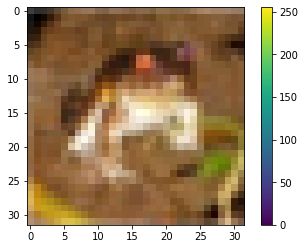

In [4]:
# 첫번째 이미지
plt.imshow(train_x[0].reshape(32, 32, 3))
plt.colorbar()
plt.show()

- 이미지를 [-1, 1]로 정규화시킨 후에 첫 번째 이미지를 확인했을 때 이미지가 어둡게 나오면서 'Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).'라는 메시지가 떴다. RGB데이터(부동 소수점의 경우 [0..1], 정수의 경우 [0..255])를 사용하여 imshow의 유효 범위로 입력 데이터를 클리핑한다는 의미로 [-1, 1]로 정규화시키지 않은 상태에서 이미지를 불러와야 경고 메시지도 없고 색도 제대로 나온다는 것을 알게 되었다.

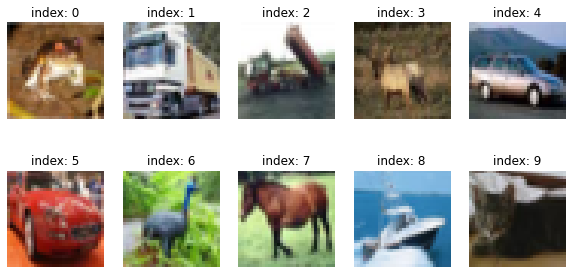

In [5]:
# for문을 이용해 10개 확인하기
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

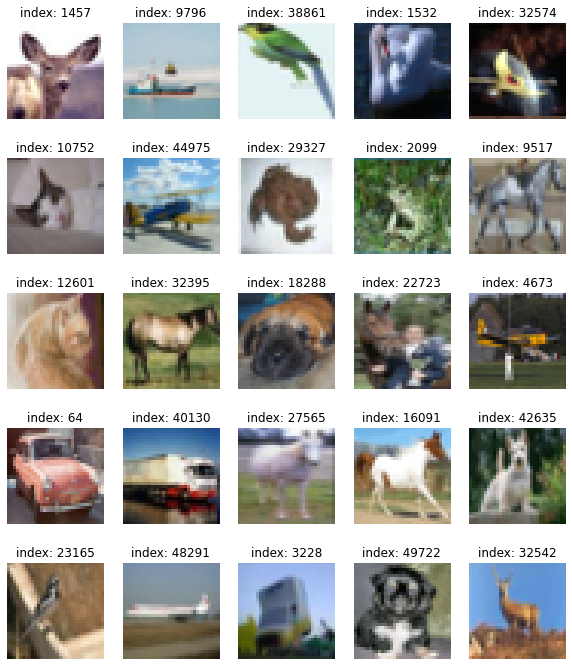

In [6]:
# 랜덤으로 25개 이미지 뽑기
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index].reshape(32, 32, 3))
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

In [7]:
# 이미지를 [-1, 1]로 정규화
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [8]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
 # 색채이미지에 대한 채널 수(3) 추가
train_x.shape

(50000, 32, 32, 3)

In [9]:
# 학습 준비
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [10]:
# 미니배치 데이터셋을 구성
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

- from_tensor_slices() 함수 : 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있다.  
- shuffle() 함수 : 데이터셋을 잘 섞어서 모델에 넣어준다.

## Step 3. 생성자 모델 구현하기

In [11]:
# DCGAN(Deep Convolutional GAN) 구현하기(생성자 구현)
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [13]:
# 랜덤 노이즈 벡터를 생성하여 결과물 만들기
noise = tf.random.normal([1, 100])

In [14]:
# 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인
generated_image = generator(noise, training=False)
 # 학습하는 중이 아니기 때문에 training=False로 설정(Batch Normalization 레이어는 훈련 시기와 추론 시기의 행동이 달라 제대로 설정해주어야 함)
generated_image.shape

TensorShape([1, 32, 32, 3])

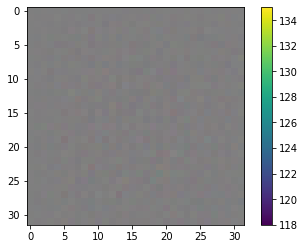

In [15]:
# 이미지 시각화
plt.imshow(np.array((generated_image[0, :, :, :]*127.5)+127.5, np.int32))
plt.colorbar()
plt.show()

- [0, :, :, :] : (32,32,3)shape의 이미지를 꺼내기 위해 0번째 축의 인덱스만 0으로 맞춰주었다.  
- RGB데이터(부동 소수점의 경우 [0..1], 정수의 경우 [0..255])를 사용하여 imshow의 유효 범위로 입력 데이터를 클리핑하기 위해서는 이미지를 [-1, 1]로 정규화시킨 것을 다시 [0~255]범위 내로 맞춰주어야 했다. 범위를 조정했음에도 계속 같은 오류가 떠서 구글링해보니 이미지에 .astype(np.uint8)를 붙여주면 해결된다는 글을 보고 시도해봤으나 AttributeError가 발생했다. 그래서 다른 방법을 시도해봤고, 위와 같이 나왔는데 제대로 나온건지 모르겠다. 아직 학습이 되지 않은 상태라 결과물이 이상한 것이라고 믿고 모델을 학습해 나가며 제대로 된 이미지를 생성하면 될 것이라고 생각했다.

## Step 4. 판별자 모델 구현하기

In [16]:
# 판별자 구현하기
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [17]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [18]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.0018784]], dtype=float32)>

- 생성 랜덤 이미지에 대한 판별자 모델이 판별한 결과값 : < tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00638635]], dtype=float32) >

## Step 5. 손실함수와 최적화 함수 구현하기

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
# generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
# discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

- discriminator_loss는 real_output(기울기) 값은 1에 가까울수록, fake_output 값은 0에 가까울수록 좋다.

In [22]:
# discriminator accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [23]:
# optimizer 정의(Adam)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

- 따로따로 학습을 진행하는 개별 네트워크이기 때문에 생성자와 구분자 따로 optimizer를 만들어주어야 한다.

## Step 6. 훈련과정 상세 기능 구현하기

In [24]:
# 100차원의 노이즈를 총 16개 만들기
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [25]:
# train step
@tf.function
def train_step(images):  # 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  # 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  # tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  # generated_images 생성

        # discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    # gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  # 리턴값

In [26]:
# train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수 만들기
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array((predictions[i, :, :, :]*127.5)+127.5, np.int32))
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

- [-1, 1]로 정규화가 된 상태이기 때문에 0~255범위로 다시 바꿔주었다.

In [27]:
# 시각화하는 함수 만들기
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [28]:
# 정기적으로 모델을 저장하기 위한 checkpoint 만들기
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Step 7. 학습 과정 진행하기

In [29]:
# 지금까지 만든 함수들 합치기
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [30]:
save_every = 5 # 저장 간격 담당
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

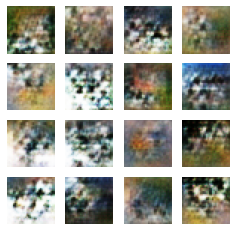

Time for training : 1495 sec


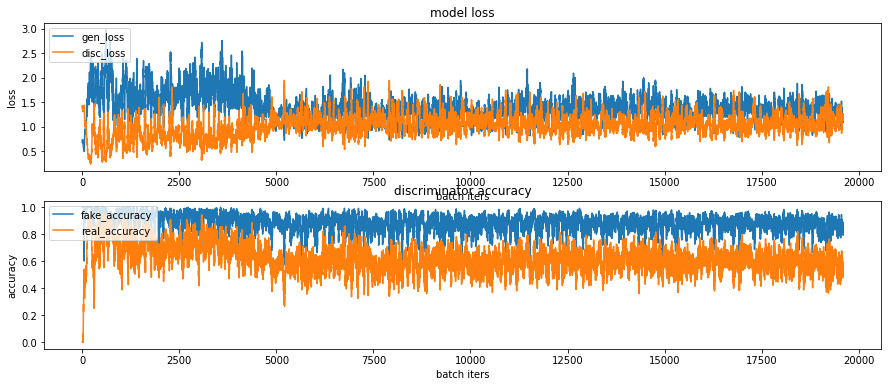

CPU times: user 25min 53s, sys: 2min 4s, total: 27min 57s
Wall time: 24min 56s


In [31]:
%%time
train(train_dataset, EPOCHS, save_every)

- Fake Image에 대한 판별자의 Accuracy(fake_accuracy)가 계속 1에 가깝게 유지되고 있다면, 생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있다는 의미이다. 위에 그래프를 보면 조금은 1에서 떨어지는 것처럼 보이긴하지만 여전히 1에 가까운 편인 거 같다. 생성자가 아직 제대로 판별자를 속이고 있는 건 아닌 거 같다.

In [34]:
# 학습 과정 시각화(학습 과정을 gif로 저장)
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1540541 Dec 19 15:10 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


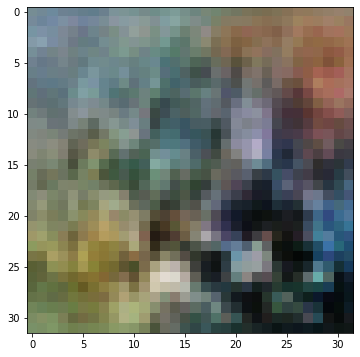

In [35]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것이다.

## Step 8. GAN 훈련 과정 개선하기
- [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)  
- [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)
- [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)  
- [Improved Techniques for Training GANs](https://proceedings.neurips.cc/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf)

--------

## 회고
1. GAN의 두 모델 구조를 통해 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였는가?  
육안으로 확실하게 구별될 만한 이미지가 생성되지 못한 거 같다. epoch을 늘린다면 더 괜찮은 이미지를 생성할 수 있지 않을까 싶다.  
2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었는가?  
육안으로 확실하게 구별될 만한 이미지가 생성되지는 못했지만 gif를 보면 생성이미지 품질이 서서히 향상되는 것은 확인할 수 있었다. fake accuracy는 조금씩 떨어지는 거 같아 보이기는 했다. 그래도 여전히 1에 가깝기 때문에 생성자가 아직 제대로 판별자를 속이고 있는 건 아닌 거 같다는 결론이 났다.  
3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 적용해보았는가?  
checkpoint는 중간중간 저장해서 수정 후 학습시간을 줄이기 위해 존재하는 거 같은데, 정확하게 이해하지 못해서 학습을 계속해서 다시 돌려볼 엄두가 안났다. 전체적으로 좀 더 정확한 이해를 한 후에 새로운 것도 시도해보고 싶다.  
4. 프로젝트를 진행하면서 느낀 점 : 지금까지는 하나의 모델로 학습시키고 판단하고 했었는데, 두 모델을 함께 학습시키고 판단하면서 쫓고 쫓기는 관계에 있는 모델을 배웠다는 점이 흥미로웠다. 아직 제대로 이해못한 부분도 있고, 많이 어려운 부분도 있지만 GAN의 두 모델이 서로 발전하는 원리도 신기했고, 시각적으로도 보기에 재미있는 것들이 많아서 GAN에 대해 더 알아가고 싶다.

## Reference
- [Clipping input data to the valid range for imshow with RGB data 해결방법 1](https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa)  
- [Clipping input data to the valid range for imshow with RGB data 해결방법 2](https://www.codegrepper.com/tpc/clipping+input+data+to+the+valid+range+for+imshow+with+rgb+data+%28%5B0..1%5D+for+floats+or+%5B0..255%5D+for+integers%29.)